### objective
This is the main notebook of the pipeline that will allow detection and prediction of the rootlet from planarian multiciliated cells

Note 13 April 2021: Data Vizualization is not implemented but I think that data are saved as a csv

## Module Loading

In [18]:
# Allow importation of the others notebook
import import_ipynb

# pyTorch: module for the neural network
import torch
import torch.nn as nn

# load excel files 
# note 13 April 2021: the module might be deprecated => yes only for .xls 
#import xlrd - Using pylightxl instead
import pylightxl as xl

# time tools
from time import time, asctime

# module that list all files in a input directory
from glob import glob
 
# module that open/save data as csv
import csv

#import asyncio   # note 13/04/2021, this module was already anotated: might be useless

# Data Vizualisation module
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

#worm_segmentation imports. I cannot import worm_segmentation functions. This is a temporary solution.
import numpy as np
from skimage.morphology import skeletonize
from PIL import Image 

# helper function 
# note 13/04/2021 instead of * each function should be load independently
from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *
from tools.Graphical_Tools import *
from tools.Centriole_Detection import *

#from tools.worm_segmentation import *

## 63/100x anti-rootletin image(s) and excel file(s)

In [19]:
# This cell load the preprocess 100x images and the corresponding excel file 
# Immunofluorescence images acquired at objective 63x or 100x 
# Excel file with midline and edge coordinate, X- and Y- shift

# 2 options are available: 
optionChosen = 2

# OPTION 1:
# analyzis of all data in a folder
if optionChosen == 1:
    tif_list = glob('./to_analyse/*.tif')
    xls_list = glob('./to_analyse/*.xlsm')

# OPTION 2:
# analyse only a specific file, put the path, and uncomment the two lines below:
elif optionChosen == 2:
    file_name = './to_analyse/160331_Vfl1_rootletin_full_10' #enter full path + file name without extension. 
    tif_list = [file_name + '.tif']                #User inputs file name only => by definition xlsm & tif share the same name.
    xls_list = [file_name + '.xlsm']
    
    
else:
    print('Option provided was not understood')

print(tif_list, xls_list)

# WARNING: 
# I'm not sure to put any Quality Check in the script, make sure that the name of both file
# .xlsm and .tif share the same name at the exception of the extension

# Note: 
# It's better to put the full path of the file, the './my_directory' is the linux equivalent of 'c:/my_directory'
# If Option 2: keep the bracket and the apostrophe ['./whateverYouNeed/xxx.xslm']

['./to_analyse/160331_Vfl1_rootletin_full_10.tif'] ['./to_analyse/160331_Vfl1_rootletin_full_10.xlsm']


### Information Cyril the 13/04/2021
 
I annotated the code but i didn't check if it work.
 
From what i looked so far, their is currently no possibility to load some already pre process data (detect centriole one day then predict their angle an other day). This might be implemented

In [20]:
def extract_worm_edge(path, nBlur, quantile = 0.01): # I am temporarily using this function here. Cannot import.
    wormImg = cv2.imread(path)
    img_gray  = cv2.cvtColor(wormImg, cv2.COLOR_BGR2GRAY)
    original_size = (img_gray.shape[0], img_gray.shape[1])
    
    img_gray = cv2.resize(img_gray, (600,300))
    
    blured = cv2.GaussianBlur(img_gray, (3,3), cv2.BORDER_DEFAULT)
    for i in range(nBlur):
        blured = cv2.GaussianBlur(blured, (3,3), cv2.BORDER_DEFAULT)
        
    
    cannyed = cv2.Canny(blured, np.quantile(blured, quantile), np.amax(blured)) 
    contours, _ = cv2.findContours(cannyed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    
    
    # Extract the longest contour
    max_len = 0
    idx = 0
    for i, an_edge in enumerate(contours):
        if len(an_edge) > max_len:
            max_len = len(an_edge)
            idx = i

    reshape_contour = np.reshape(contours[idx], (contours[idx].shape[0], 2))
    full_worm = np.append(reshape_contour, reshape_contour[0])

        
    ### 
    # Midline Extraction
    # Fill the worm
    img_pl = np.zeros((cannyed.shape[0],cannyed.shape[1]))
    cv2.fillPoly(img_pl,pts=contours,color=(1))
    
    
    # Skeletonize to get the midline
    skeletonized = skeletonize(img_pl)
    print(len(skeletonized))
    # Extract coordinate of skeletonized
    skeleton_flatten = skeletonized.flatten()
    midlineList = []
    Y = skeletonized.shape[0]
    X = skeletonized.shape[1]

    for idx, a_pixel in enumerate(skeleton_flatten):
        if a_pixel:
            midlineList.append((idx%X+1, idx//X+1))

    cv2.imshow('blured', blured)
    #cv2.imshow('skeleton', skeletonized)
    cv2.imshow('img_pl', img_pl)
    cv2.waitKey(0)
    
    # EDGE: X/Y formatting to plot the result        
    worm_edge = np.reshape(full_worm, (full_worm.shape[0]//2, 2))

    x_edge = []
    y_edge = []
    for coord in worm_edge:
        x_edge.append(coord[0])
        y_edge.append(coord[1])  
        
    # MIDLINE: X/Y formatting to plot the result
    x_midline = []
    y_midline = []
    for coord in midlineList:
        x_midline.append(coord[0])
        y_midline.append(coord[1])  
    
    
    ###################################################################################""
    '''newDim = (int(img_pl.shape[0]*1.1) , int(img_pl.shape[0]*1.1))
    resized = cv2.resize(img_pl, newDim, interpolation = cv2.INTER_LINEAR)
    skeleton2 = skeletonize(resized)
    marginX = (newDim[1] - img_pl.shape[1])//2
    marginY = (newDim[0] - img_pl.shape[0])//2
    skeleton2 = skeleton2[marginY:-(marginY+1), marginX: -(marginX+1)]
    skeleton2 = np.array(skeleton2, dtype='uint8')
    skeleton2 = cv2.resize(skeleton2, img_pl.shape, interpolation = cv2.INTER_LINEAR)
    
    skeleton_flatten2 = skeleton2.flatten()
    midlineList2 = []
    Y2 = skeleton2.shape[0]
    X2 = skeleton2.shape[1]

    for idx, a_pixel in enumerate(skeleton_flatten2):
        if a_pixel:
            midlineList2.append((idx%X+1, idx//X+1))
    
    x_midline2 = []
    y_midline2 = []
    for coord in midlineList2:
        x_midline2.append(coord[0])
        y_midline2.append(coord[1])  
    '''
    ########################################################################################""
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.imshow(img_gray, 'gray')
    ax.plot(x_edge, y_edge, 'red')
    ax.plot(x_midline, y_midline, 'blue')
    #ax.plot(x_midline2, y_midline2, 'green')
    plt.show()
    
    return (x_midline, y_midline), (x_edge, y_edge)

In [26]:
# THIS IS A TESTING CELL. NOT A DUPLICATE OF THE NEXT CELL.

# Do you want to save as image the intermediate result (DOG, find_maxima, DOG+find_maxima)
# It's memory consuming but since this algorithm is very slow it's better to save the result
# especially for publication purpose
SAVE_INTERMEDIATE_IMG = True

# Do you want to load the 'skeleton' of the worm (midline & edge)
LOAD_MIDLINE_AND_EDGE_FROM_EXCEL = True 

# Loop that will analyze one by one all the file define above.
for pathExcel, pathImg_100x in zip(xls_list, tif_list):
    
    # print the time when the file start to be compute and the name of both file
    print(f"{asctime()}")
    print(f"Exl file loaded: {pathExcel}")
    print(f"Tif file loaded: {pathImg_100x}") 
    
    # Are you just testing the angle compensation?
    Test_Angle_Compensation = False

    path_img_10x   = './full_worm/C1-180417_Dvl1_2_Odf2-injection_root_17dpa_10x_Full_1.tif'

    problem = 'classification'

# MIDLINE AND WORM EDGE    
    
# 13/04/2021: In the future 2 options might be available: 
# Either the midline and edge will be draw manually with ImageJ
# Or an automatic algorithm will do the job
# Currently the automatic version is not available

    # Load Midline and Edge coordinates from a 'classical' excel file
    if LOAD_MIDLINE_AND_EDGE_FROM_EXCEL:
# 13/04/2021: To Raphael: perfect example of why it's better to load function individually and not with a *
# it have been easier for me to find it and know what function is doing exactly

# 13/04/2021: get_xls_values() function opens excel file and loads the coordinates 
# for midline and edge in this excel file
        db = get_xls_values(pathExcel)
        x_mid = db['worm_midline']['x']
        y_mid = db['worm_midline']['y']
        x_edg = db['worm_edge']['x']
        y_edg = db['worm_edge']['y']
        
        # Invert the y axis for edge and midline
# 13/04/2021: If i remember well, that's require because imageJ have an invertex y axis (the (0,0) coordinate
# is in top left corner, and we want it bottom left corner)
        newY_mid, newY_edg = [], [] 
        for y in y_mid:
            newY_mid.append(-y)

        for y in y_edg:
            newY_edg.append(-y)

        # 'skeleton' of the worm
        worm = [x_mid, newY_mid, x_edg, newY_edg ]
        
        
     # Automatic characterization of the midline and the edge
    ## So far (17 November 2020) do not work at all. 
    ## Ideas: size of the image, contrast (rm background per example)
    else:
        midline, edge = extract_worm_edge(path_img_10x, nBlur = 2, quantile = 0.01)
        worm = [midline[0], midline[1], edge[0], edge[1]]
    #code works until here
    
    # Reformat midline and Edge in a given number of segment and subsegment
    midline_final = aggregate_segment_char(worm[0], worm[1], 
                                           worm[2], worm[3], 
                                           n_midline_seg = 50, 
                                           n_sub_segment = 25, 
                                           n_edge_seg = 200)


    print(f'{asctime()}: Edge and Midline reformated')

# CENTRIOLES IDENTIFICATION
    
    # load the 100x image using OpenCV
    img = cv2.imread(pathImg_100x, cv2.IMREAD_UNCHANGED)
    print(f'{asctime()}: Image Loaded')

    # Compute differential of Gaussian then Otsu thresholding to try to get a mask of the centriole
    # return a binary image
    dog_img = dog_and_otsu(img)
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray((dog_img * 255).astype(np.uint8)) #updated this line. PIL pckg does not support [0-1] 
        newPath = pathImg_100x[:-4] + '_dog_otsu.tif'
        img_to_save.save(newPath)
        
    print(f'{asctime()}: Dog & Otsu computed ')

    
    # detect centriole using find_maxima algorithm 
    # note: find_maxima() is the implementation of the find_maxima module in imageJ
    # return a binary image
    find_maxima_img = find_maxima(img)
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray((find_maxima_img * 255).astype(np.uint8))  #updated this line
        newPath = pathImg_100x[:-4] + '_find_maxima.tif'
        img_to_save.save(newPath)
        
    print(f'{asctime()}: Find Maxima Computed')

    
    # combine the 2 previous approaches to get the final 
    # return a binary image
    combine_img = dog_img*find_maxima_img
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray((combine_img * 255).astype(np.uint8)) #updated this line
        newPath = pathImg_100x[:-4] + '_centriole_detected.tif'
        img_to_save.save(newPath)
    print(f'{asctime()}: Centriole detected')

Wed Apr 21 09:15:08 2021
Exl file loaded: ./to_analyse/160331_Vfl1_rootletin_full_10.xlsm
Tif file loaded: ./to_analyse/160331_Vfl1_rootletin_full_10.tif
Wed Apr 21 09:15:10 2021: Edge and Midline reformated
Wed Apr 21 09:15:11 2021: Image Loaded
Wed Apr 21 09:15:13 2021: Differential of Gaussian performed
Wed Apr 21 10:43:09 2021: Thresholding performed
 Wed Apr 21 10:43:15 2021: Object size thresholded
Wed Apr 21 10:43:16 2021: Dog & Otsu computed 
Centriole detected  67051
Wed Apr 21 11:19:32 2021: Find Maxima Computed
Wed Apr 21 11:19:33 2021: Centriole detected


In [30]:
if torch.cuda.is_available():                                  
    device = torch.device('cuda')
    print('Running on cuda')
else:
    device = torch.device('cpu')
    print('Running on cpu')

# Loading the Neural Network (VGG_Schmidtea) and the Weight of the network ()
#13/04/2021: only classification is working, the path below do not exist, the appropriate weigth might be:
# './weight/VGG_schmidtea_weight_classification_noReLu_80percent_classification_n72.pth'
if problem == 'classification':
    model = VGG_Schmidtea(n_classes = 72).to(device)
    model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))
else:
    model = VGG_Schmidtea(n_classes = 1).to(device)
    model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_regression.pth', map_location = device))

# Put the model in evaluation/prediction mode
model.eval()

# Extraction of coordinates where centrioles are
ypts, xpts = np.where(combine_img == 1)

a_list_of_centriole = []

x_shape, y_shape = img.shape[1], img.shape[0] 
xlim, ylim  = x_shape - 16 , y_shape - 16
for i in range(len(ypts)):
    x, y = xpts[i], ypts[i]

    if y > 16 and x > 16 and y < ylim and x < xlim:
        #centriole_extracted = img.crop((xpts[i], ypts[i], xpts[i] + 32, ypts[i] + 32))
        centriole = img[y-16:y+16, x-16:x+16]
        centriole = np.asarray(centriole, dtype = "uint8")
        centriole = centriole.reshape(1 , 1, 32, 32)
        # Inside predictor:
        centriole = torch.from_numpy(centriole)
        centriole = centriole.float().to(device)

        with torch.no_grad():
            output = model(centriole)

        angle = output.max(1)[1]
        angle = angle.numpy()

        #print(centriole_extracted)
        #angle = predictor(model, centriole_extracted, device, problem = 'classification')
        a_list_of_centriole.append(((xpts[i], ypts[i]), angle[0]))


print(f'{asctime()}: Centrioles angle predicted and compensated')

Running on cpu
Wed Apr 21 11:39:45 2021: Centrioles angle predicted and compensated


In [32]:
###############################################
# CENTRIOLE REPOSITIONNING ET REORIENTATION
###############################################

shiftX = db['image_shift']['x']
shiftY = db['image_shift']['y']
shifted_centriole_list = []

for a_centriole in a_list_of_centriole:
    xShifted = a_centriole[0][0] + shiftX
    yShifted = a_centriole[0][1] + shiftY
    if problem == 'classification':
        shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]*5+2.5))
    else:
        shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]))



reoriented_centriole = []
for a_centriole in shifted_centriole_list:
    tmp_list = list(centriole_characterizator(a_centriole, midline_final))
    if db['worm_orientation'] == 'gauche' or db['worm_orientation'] == 'left':
        tmp_list[-2] = 1 - tmp_list[-2]
        tmp_list[-1] = math.degrees(math.atan2(-math.sin(math.radians(tmp_list[-1])), -math.cos(math.radians(tmp_list[-1]))))
    tmp_list.insert(1,a_centriole[0][0])
    tmp_list.insert(2,a_centriole[0][1])

    reoriented_centriole.append(tmp_list)

# Save
newPath = pathImg_100x[:-4] + '_DATA.csv'
with open(newPath, 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(reoriented_centriole)


print(f'{asctime()}: Centriole Dataset reformated')



print("\n")

Wed Apr 21 11:43:57 2021: Centriole Dataset reformated




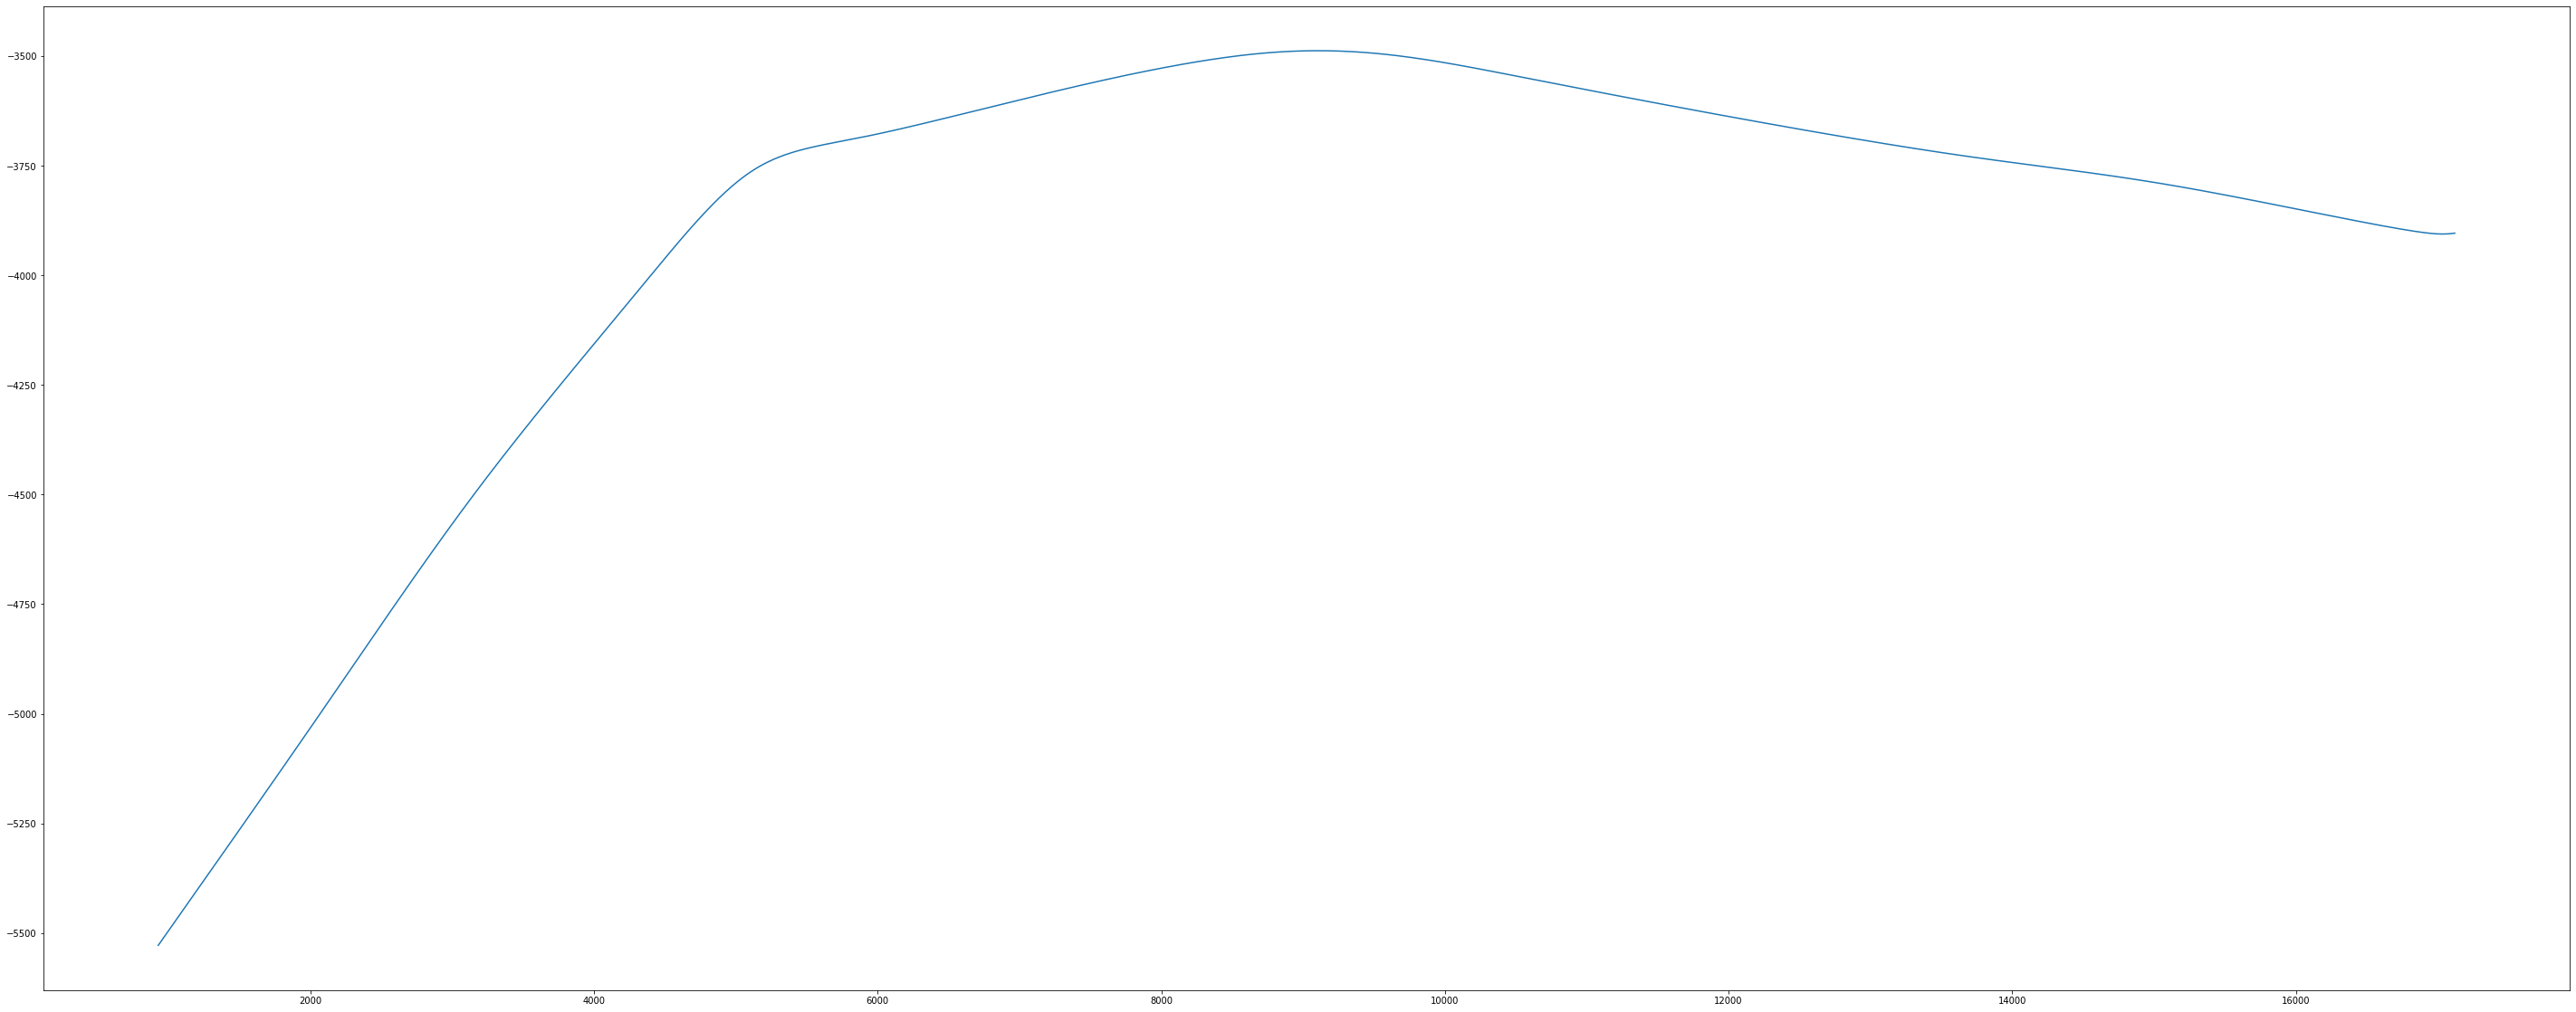

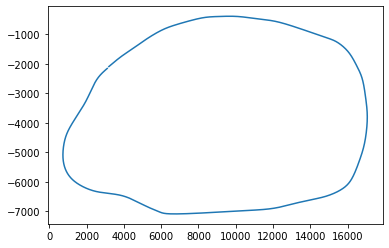

 Idx | Angle |Lateral| Longi   || Marker | Color
------------------------------------------------
   0 |  -30  |  0.80 |  0.55   ||   o    | darkorange


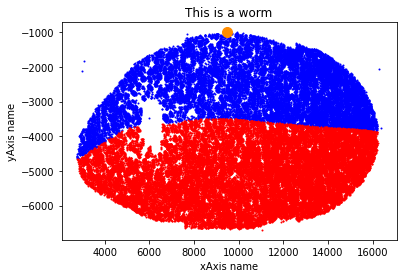

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


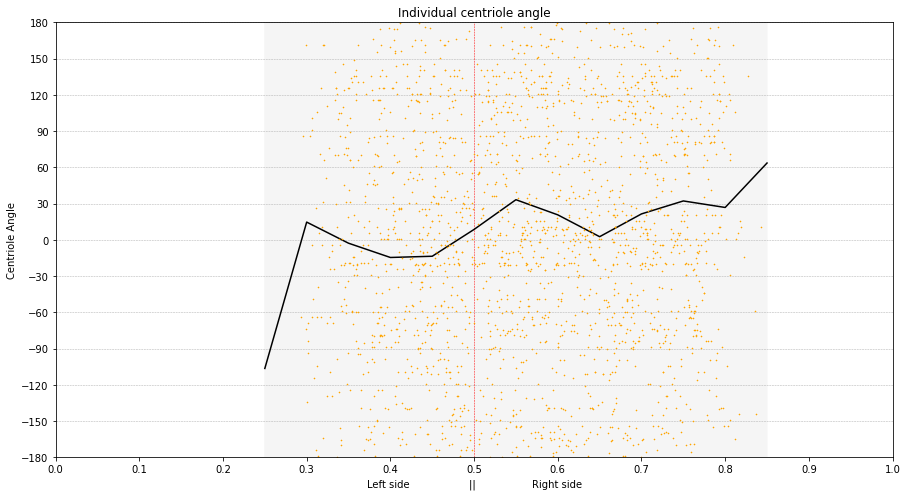

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


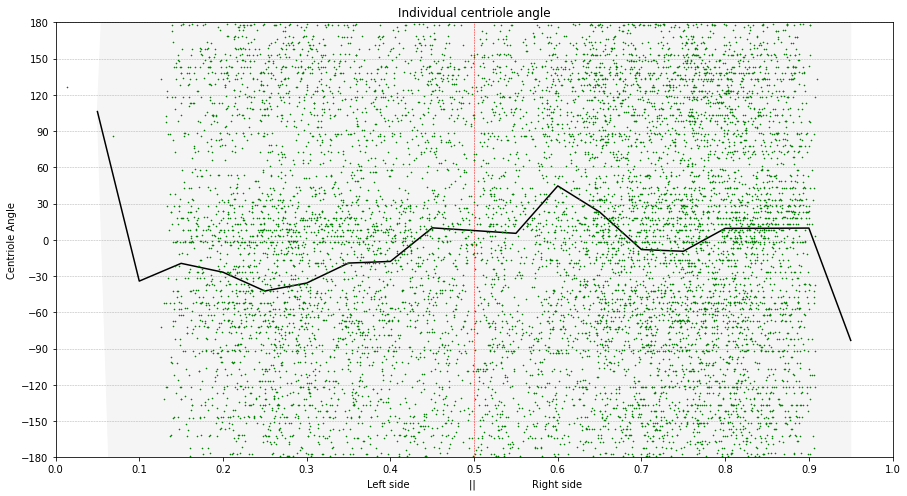

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


In [ ]:
#######################################################
# Graphical representation of the results
# Code above is not mandatory
#######################################################

# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [0]

# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = None
Y_coordinate = None

save_path = pathImg_100x[:-4] + '_schema.tif'
Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate), save = True, path = pathImg_100x[:-4])

# Print The graph (worms segmented in 5 antero-posterior parts) + moving average + cstd
for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05, save = True, path = pathImg_100x[:-4])

# Overlap the analysed image with the identified and analyzed centriole represented as an arrow indicating the predicted angle
# The starting point of the arrow is the origin of the detected centriole
# The Ending point indicate the predicted orientation of the centriole

save_figure = True

# Each color correspond to a class of 5°
# So far the color or 'randomly' attributed for each class

# Define the length of the arrow
arrowLen = 5

# Compute as X/Y coordinates the property of the arrow
# WARNING: 18/11/2020. FOR AN UNKNOWN REASON, the angle is rotated by 90° -> I need to check why
DATA = []

for i in a_list_of_centriole:
    angle = i[1] + 90
    x = i[0][0]
    y = i[0][1]
    new_coord = [x-arrowLen*math.cos(math.radians(angle)), y-arrowLen*math.sin(math.radians(angle)), x+arrowLen*math.cos(math.radians(angle)), y+arrowLen*math.sin(math.radians(angle)), angle]
    DATA.append(new_coord)

DATA = np.array(DATA)

cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

plt.figure(figsize=(100,50))

plt.imshow(img)

for idx in range(0,len(DATA[:,1])):
    colorVal = scalarMap.to_rgba(DATA[idx,4])
    plt.arrow(DATA[idx,0],  #x1
              DATA[idx,1],  # y1
              DATA[idx,2]-DATA[idx,0], # x2 - x1
              DATA[idx,3]-DATA[idx,1], # y2 - y1
              color=colorVal)
if save_figure: 
    savePath = pathImg_100x[:-4] + '_Detected_Angle.tif'
    plt.savefig(savePath)

with open('./file_treated.csv', 'a', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(tif_list[i])
print(f"{asctime()}")
print("\n")

plt.show()

[0]


In [40]:
# Do you want to save as image the intermediate result (DOG, find_maxima, DOG+find_maxima)
# It's memory consuming but since this algorithm is very slow it's better to save the result
# especially for publication purpose
SAVE_INTERMEDIATE_IMG = True

# Do you want to load the 'skeleton' of the worm (midline & edge)
LOAD_MIDLINE_AND_EDGE_FROM_EXCEL = True # This should not be ther

# Loop that will analyze one by one all the file define above.
for pathExcel, pathImg_100x in zip(xls_list, tif_list):
    
    # print the time when the file start to be compute and the name of both file
    print(f"{asctime()}")
    print(f"Exl file loaded: {pathExcel}")
    print(f"Tif file loaded: {pathImg_100x}") 

    

    # Are you just testing the angle compensation?
    Test_Angle_Compensation = False

    path_img_10x   = '../full_worm/C1-180417_Dvl1&2_Odf2-injection_root_17dpa_10x_Full_1.tif'

    problem = 'classification'


# MIDLINE AND WORM EDGE    
    
# 13/04/2021: In the future 2 options might be available: 
# Either the midline and edge will be draw manually with ImageJ
# Or an automatic algorithm will do the job
# Currently the automatic version is not available

    # Load Midline and Edge coordinates from a 'classical' excel file
    if LOAD_MIDLINE_AND_EDGE_FROM_EXCEL:

# 13/04/2021: To Raphael: perfect example of why it's better to load function individually and not with a *
# it have been easier for me to find it and know what function is doing exactly

# 13/04/2021: it looks like the get_xls_values() function open the excel file and load the coordinates 
# for midline and edge in this excel file
        db = get_xls_values(pathExcel)

        x_mid = db['worm_midline']['x']
        y_mid = db['worm_midline']['y']
        x_edg = db['worm_edge']['x']
        y_edg = db['worm_edge']['y']

        # Invert the y axis for edge and midline
# 13/04/2021: If i remember well, that's require because imageJ have an invertex y axis (the (0,0) coordinate
# is in top left corner, and we want it bottom left corner)
        newY_mid, newY_edg = [], []
        for y in y_mid:
            newY_mid.append(-y)

        for y in y_edg:
            newY_edg.append(-y)

        # 'skeleton' of the worm
        worm = [x_mid, newY_mid, x_edg, newY_edg ]


    # Automatic characterization of the midline and the edge
    ## So far (17 November 2020) do not work at all. 
    ## Ideas: size of the image, contrast (rm background per example)
    else:
        midline, edge = extract_worm_edge(path_img_10x, quantile = 0.01)
        worm = [midline[0], midline[1], edge[0], edge[1]]

    
    # Reformat midline and Edge in a given number of segment and subsegment
    midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                           x_edg, newY_edg, 
                                           n_midline_seg = 50, 
                                           n_sub_segment = 25, 
                                           n_edge_seg = 200)


    print(f'{asctime()}: Edge and Midline reformated')

# 13/04/2021: improvment possibility of the previous function: perform an interpolation of the midline
# instead of using segment
# might be possible to do it as well for the edge, but perhaps harder because edge is circular



# CENTRIOLES IDENTIFICATION
    
    # load the 100x image using OpenCV
    img = cv2.imread(pathImg_100x, cv2.IMREAD_UNCHANGED)
    print(f'{asctime()}: Image Loaded')

    # Compute differential of Gaussian then Otsu thresholding to try to get a mask of the centriole
    # return a binary image
    dog_img = dog_and_otsu(img)
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray(dog_img)
        newPath = pathImg_100x[:-4] + '_dog_otsu.tif'
        img_to_save.save(newPath)
        
    print(f'{asctime()}: Dog & Otsu computed ')

    
    # detect centriole using find_maxima algorithm 
    # note: find_maxima() is the implementation of the find_maxima module in imageJ
    # return a binary image
    find_maxima_img = find_maxima(img)
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray(find_maxima_img)
        newPath = pathImg_100x[:-4] + '_find_maxima.tif'
        img_to_save.save(newPath)
        
    print(f'{asctime()}: Find Maxima Computed')

    
    # combine the 2 previous approaches to get the final 
    # return a binary image
    combine_img = dog_img*find_maxima_img
    
    if SAVE_INTERMEDIATE_IMG:
        img_to_save = Image.fromarray(combine_img)
        newPath = pathImg_100x[:-4] + '_centriole_detected.tif'
        img_to_save.save(newPath)
    print(f'{asctime()}: Centriole detected')

    
# 13/04/2021: I'm almost sure that all the code above this comment work fine.
# Due to some comment in the code, it looks like the code below will not work

# ANGLE PREDICITON OF THE CENTRIOLE

# The prediction is perfomed thanks to a neural network implemented in Python using the pyTorch package

    # Define where the prediction will be perform (on cpu or on gpu (graphic card))
    # using the gpu require an Nvidia graphic card with cuda installed
#13/04/2021: to train a model it's mandatory to use CUDA, to predict the orientation of 'only' 100k
# i don't know how much time it will take to use a cpu. using google Colab might be mandatory
    if torch.cuda.is_available():                                  
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Loading the Neural Network (VGG_Schmidtea) and the Weight of the network ()
#13/04/2021: only classification is working, the path below do not exist, the appropriate weigth might be:
# './weight/VGG_schmidtea_weight_classification_noReLu_80percent_classification_n72.pth'
    if problem == 'classification':
        model = VGG_Schmidtea(n_classes = 72).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))
    else:
        model = VGG_Schmidtea(n_classes = 1).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_regression.pth', map_location = device))

    # Put the model in evaluation/prediction mode
    model.eval()
    
# 13/04/2021: End of my code review, the code below need to be checked properly 
############################################################################################################
    # I don't know how the centriole image will come but to do the prediction:

    # Extraction of coordinates where centrioles are
    ypts, xpts = np.where(combine_img == 1)

    a_list_of_centriole = []

    x_shape, y_shape = img.shape[1], img.shape[0] 
    xlim, ylim  = x_shape - 16 , y_shape - 16
    for i in range(len(ypts)):
        x, y = xpts[i], ypts[i]

        if y > 16 and x > 16 and y < ylim and x < xlim:
            #centriole_extracted = img.crop((xpts[i], ypts[i], xpts[i] + 32, ypts[i] + 32))
            centriole = img[y-16:y+16, x-16:x+16]
            centriole = np.asarray(centriole, dtype = "uint8")
            centriole = centriole.reshape(1 , 1, 32, 32)
            # Inside predictor:
            centriole = torch.from_numpy(centriole)
            centriole = centriole.float().to(device)

            with torch.no_grad():
                output = model(centriole)

            angle = output.max(1)[1]
            angle = angle.numpy()

            #print(centriole_extracted)
            #angle = predictor(model, centriole_extracted, device, problem = 'classification')
            a_list_of_centriole.append(((xpts[i], ypts[i]), angle[0]))


    print(f'{asctime()}: Centrioles angle predicted and compensated')


    ###############################################
    # CENTRIOLE REPOSITIONNING ET REORIENTATION
    ###############################################

    shiftX = db['image_shift']['x']
    shiftY = db['image_shift']['y']
    shifted_centriole_list = []

    for a_centriole in a_list_of_centriole:
        xShifted = a_centriole[0][0] + shiftX
        yShifted = a_centriole[0][1] + shiftY
        if problem == 'classification':
            shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]*5+2.5))
        else:
            shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]))



    reoriented_centriole = []
    for a_centriole in shifted_centriole_list:
        tmp_list = list(centriole_characterizator(a_centriole, midline_final))
        if db['worm_orientation'] == 'gauche' or db['worm_orientation'] == 'left':
            tmp_list[-2] = 1 - tmp_list[-2]
            tmp_list[-1] = math.degrees(math.atan2(-math.sin(math.radians(tmp_list[-1])), -math.cos(math.radians(tmp_list[-1]))))
        tmp_list.insert(1,a_centriole[0][0])
        tmp_list.insert(2,a_centriole[0][1])

        reoriented_centriole.append(tmp_list)

    # Save
    newPath = pathImg_100x[:-4] + '_DATA.csv'
    with open(newPath, 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(reoriented_centriole)


    print(f'{asctime()}: Centriole Dataset reformated')



    print("\n")
    
    #######################################################
    # Graphical representation of the results
    # Code above is not mandatory
    #######################################################
    
    # If you want to see some specific centrioles, add them in the list
    list_of_desired_centriole = [0]

    # If you want to see the location of a specific coordinate (Write None if you don't want to see them )
    X_coordinate = None
    Y_coordinate = None

    save_path = pathImg_100x[:-4] + '_schema.tif'
    Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate), save = True, path = pathImg_100x[:-4])
    
    # Print The graph (worms segmented in 5 antero-posterior parts) + moving average + cstd
    for i in range(5):
        print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05, save = True, path = pathImg_100x[:-4])
        
    # Overlap the analysed image with the identified and analyzed centriole represented as an arrow indicating the predicted angle
    # The starting point of the arrow is the origin of the detected centriole
    # The Ending point indicate the predicted orientation of the centriole

    save_figure = True

    # Each color correspond to a class of 5°
    # So far the color or 'randomly' attributed for each class

    # Define the length of the arrow
    arrowLen = 5

    # Compute as X/Y coordinates the property of the arrow
    # WARNING: 18/11/2020. FOR AN UNKNOWN REASON, the angle is rotated by 90° -> I need to check why
    DATA = []

    for i in a_list_of_centriole:
        angle = i[1] + 90
        x = i[0][0]
        y = i[0][1]
        new_coord = [x-arrowLen*math.cos(math.radians(angle)), y-arrowLen*math.sin(math.radians(angle)), x+arrowLen*math.cos(math.radians(angle)), y+arrowLen*math.sin(math.radians(angle)), angle]
        DATA.append(new_coord)

    DATA = np.array(DATA)

    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

    plt.figure(figsize=(100,50))

    plt.imshow(img)

    for idx in range(0,len(DATA[:,1])):
        colorVal = scalarMap.to_rgba(DATA[idx,4])
        plt.arrow(DATA[idx,0],  #x1
                  DATA[idx,1],  # y1
                  DATA[idx,2]-DATA[idx,0], # x2 - x1
                  DATA[idx,3]-DATA[idx,1], # y2 - y1
                  color=colorVal)
    if save_figure: 
        savePath = pathImg_100x[:-4] + '_Detected_Angle.tif'
        plt.savefig(savePath)
        
    with open('./file_treated.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(tif_list[i])"""
    print(f"{asctime()}")
    print("\n")

#plt.show()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-40-44994dfb3a1a>, line 306)

In [4]:
# Overlap the analysed image with the identified and analyzed centriole represented as an arrow 
# indicating the predicted angle
# The starting point of the arrow is the origin of the detected centriole
# The Ending point indicate the predicted orientation of the centriole

save_figure = True
show_figure = True

# Each color correspond to a class of 5°
# So far the color or 'randomly' attributed for each class

# Define the length of the arrow
arrowLen = 5

# Compute as X/Y coordinates the property of the arrow
# WARNING: 18/11/2020. FOR AN UNKNOWN REASON, the angle is rotated by 90° -> I need to check why
DATA = []

for i in a_list_of_centriole:
    angle = i[1] + 90
    x = i[0][0]
    y = i[0][1]
    new_coord = [x-arrowLen*math.cos(math.radians(angle)), y-arrowLen*math.sin(math.radians(angle)), x+arrowLen*math.cos(math.radians(angle)), y+arrowLen*math.sin(math.radians(angle)), angle]
    DATA.append(new_coord)
    
DATA = np.array(DATA)

cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

plt.figure(figsize=(100,50))

plt.imshow(img)

for idx in range(0,len(DATA[:,1])):
    colorVal = scalarMap.to_rgba(DATA[idx,4])
    plt.arrow(DATA[idx,0],  #x1
              DATA[idx,1],  # y1
              DATA[idx,2]-DATA[idx,0], # x2 - x1
              DATA[idx,3]-DATA[idx,1], # y2 - y1
              color=colorVal)
if save_figure: 
    savePath = pathImg_100x[:-4] + '_Detected_Angle.tif'
    plt.savefig(savePath)

if show_figure:
    plt.show()  

NameError: name 'a_list_of_centriole' is not defined

In [ ]:
# Graphical Representation of the worms and the analyzed centrioles
# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [0]

# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = None
Y_coordinate = None

save_path = pathImg_100x[:-4] + '_schema.tif'
Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate), save_path, save = True)

In [ ]:
# Graphical representation of the results 
for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05)

In [1]:
print('\t connard')

	 connard


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++